In [12]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import json
import numpy as np
from matplotlib import pyplot as plt

from lib.BBData import character_dict
from lib.BBDataLoad import open_char_dataset, process_char_dataset
from lib.metrics.persgraph_classifier import TVShowGraphDataset, PersGRAPH_classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
characters = list(character_dict.keys())
characters_noDefault = list(character_dict.keys())
characters_noDefault.remove('Default')

character = 'Barney'
base_folder = os.getcwd()
data_folder = os.path.join(base_folder, 'Data')
pt_folder = os.path.join(base_folder, 'Data', 'pt_graphs')
characters_folder = os.path.join(data_folder, 'Characters')
model_path = os.path.join(os.getcwd(), 'models', 'persgraph_classifier')
figsize = (8, 8)

---

In [10]:
persgraph_cls = PersGRAPH_classifier(model_path, use_cuda=True)
# persgraph_cls.set_characters(characters)
# persgraph_cls.create_data(data_folder, characters_folder, 
#                           verbose=True, override_graphs = True)

In [4]:
count_data = [0 for c in characters]
folderset_path = join(data_folder, 'graphs', 'trainSet')

for jsonfile in os.listdir(folderset_path):
    graph = join(folderset_path, jsonfile)

    with open(graph, "r") as file:
        graphConversation = json.load(file)
        yonehot = graphConversation['y']
        count_data[np.argmax(yonehot)] += 1

count_data

[3303, 7414, 653, 1724, 1515, 95, 5238, 4758, 9394]

---

In [4]:
X_train, X_valid, X_test = persgraph_cls.get_data(pt_folder, batch_size=512)

In [11]:
train_histories = persgraph_cls.train(X_train, X_valid, epochs=100, optimizer='adamw')

## Valid epoch = 99: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s, valid_loss=1.67, valid_f1score=0.476]


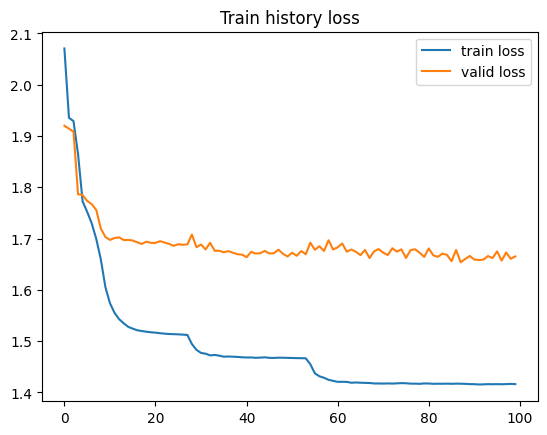

In [18]:
plt.plot(train_histories[0])
plt.plot(train_histories[2])
plt.legend(['train loss', 'valid loss'])
plt.title('Train history loss')
plt.show()

In [23]:
persgraph_cls.compute(X_test)

## Test : 100%|██████████| 27/27 [00:50<00:00,  1.88s/it]


0.4350205615644702